In [20]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [5]:
# Chargement du fichier après pre-processing
df = pd.read_csv('data_pre_process.csv', index_col = 0)
display(df.head())


,designation,description,productid,imageid,prdtypecode,lang_designation,lang_description,designation_in_description_ratio,description_complete,lang_description_complete,description_complete_length
0,olivia personalisiertes notizbuch seiten punkt...,olivia personalisiertes notizbuch seiten punkt...,3804725264,1263597046,10,de,de,1.0,olivia personalisiertes notizbuch seiten punkt...,de,59
1,journal art marche salon asiatique paris jacqu...,journal art marche salon asiatique paris jacqu...,436067568,1008141237,2280,fr,fr,1.0,journal art marche salon asiatique paris jacqu...,fr,119
2,grand stylet ergonomique bleu gamepad nintendo...,pilot style touch pen marque speedlink stylet ...,201115110,938777978,50,en,fr,1.0,grand stylet ergonomique bleu gamepad nintendo...,fr,567
3,peluche donald europe disneyland marionnette d...,peluche donald europe disneyland marionnette d...,50418756,457047496,1280,fr,fr,1.0,peluche donald europe disneyland marionnette d...,fr,50
4,guerre tuques,luc idées grandeur veut organiser jeu guerre b...,278535884,1077757786,2705,fr,fr,0.5,guerre tuques luc idées grandeur veut organise...,fr,118


In [6]:
# Afficher le nombre de lignes et de colonnes de chacun des deux fichiers
print("Le nombre de lignes et de colonnes de df est de :",df.shape)

Le nombre de lignes et de colonnes de df est de : (78822, 11)


In [7]:
from imblearn.under_sampling import RandomUnderSampler

# Affectation de X et y
X = df['description_complete']
y = df['prdtypecode']

In [9]:
# Créer une instance de RandomUnderSampler
## (auto) équlibrage des classes en réduisant les classes à la même taille que celle de la classe minoritaire.
## replacement = False --> sous-ensembles composées d'échantillons uniques.

rus = RandomUnderSampler(sampling_strategy = 'auto', replacement = False, random_state = 42)

In [10]:
# Application de rus à X et y
# Note : rus s'attend à ce que X soit un df, donc nous devons le convertir en df
X_ru, y_ru = rus.fit_resample(X.to_frame(), y)

In [14]:
# Vérifier la distribution des classes après sous-échantillonnage
print('Classes échantillon après rus :', dict(pd.Series(y_ru).value_counts()))

## rus à fonctionné, on a bien le même nombre d'exemples dans chaque classe.

Classes échantillon après rus : {10: 624, 1920: 624, 2705: 624, 2585: 624, 2583: 624, 2582: 624, 2522: 624, 2462: 624, 2403: 624, 2280: 624, 2220: 624, 2060: 624, 1940: 624, 1560: 624, 40: 624, 1320: 624, 1302: 624, 1301: 624, 1300: 624, 1281: 624, 1280: 624, 1180: 624, 1160: 624, 1140: 624, 60: 624, 50: 624, 2905: 624}


In [15]:
# Après le sous-échantillonnage
print(X_ru.shape, y_ru.shape)  
## Vérification si X_ru et y_ru ont le même nombre de lignes : ok


(16848, 1) (16848,)


In [16]:
# Convertissez X_ru en DataFrame si nécessaire
X_ru_df = X_ru.to_frame() if isinstance(X_ru, pd.Series) else X_ru
## df pour garantir la compatibilité avec les process de ML

In [17]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_ru_df, y_ru, test_size=0.2, random_state=42)

In [70]:
# Vérifiez à nouveau les dimensions
print(X_train.shape, y_train.shape)  
## Les dimensions correspondent bien : ok

(13478, 1) (13478,)


In [19]:
# Vérification que X_train contient des données textuelles
is_textual_data = all(isinstance(text, str) for text in X_train.iloc[:, 0])
print("Les données de X_train sont-elles textuelles ?", is_textual_data)


Les données de X_train sont-elles textuelles ? True


In [26]:
# Pipeline simplifié pour le test
pipeline_test = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state = 42))
])

## tfidf : vectorisation
## rf : modele ML

In [27]:
# Grille de paramètres réduite pour sqrt
param_grid_test_sqrt = {
    'tfidf__max_features': [2000, 3000, 5000],
    'rf__n_estimators': [50, 100],
    'rf__max_features': ['sqrt'],
}

In [28]:
# Grille de paramètres réduite pour log2
param_grid_test_log2 = {
    'tfidf__max_features': [2000, 3000, 5000],
    'rf__n_estimators': [50, 100],
    'rf__max_features': ['log2'],
}

In [34]:
# GridSearchCV avec la grille réduite 'sqrt'
grid_search_test_sqrt = GridSearchCV(pipeline_test, param_grid_test_sqrt, cv = 5, scoring = 'f1_weighted')

# Exécution du GridSearchCV avec la grille réduite
grid_search_test_sqrt.fit(X_train, y_train)
print("Meilleurs Paramètres (Test):", grid_search_test_sqrt.best_params_)
print("Meilleure Précision (Test):", grid_search_test_sqrt.best_score_)

Meilleurs Paramètres (Test): {'rf__max_features': 'sqrt', 'rf__n_estimators': 100, 'tfidf__max_features': 5000}
Meilleure Précision (Test): 0.6807318288509434


In [35]:
# GridSearchCV avec la grille réduite 'log2'
grid_search_test_log2 = GridSearchCV(pipeline_test, param_grid_test_log2, cv = 5, scoring = 'f1_weighted')

# Exécution du GridSearchCV avec la grille réduite
grid_search_test_log2.fit(X_train, y_train)
print("Meilleurs Paramètres (Test):", grid_search_test_log2.best_params_)
print("Meilleure Précision (Test):", grid_search_test_log2.best_score_)

Meilleurs Paramètres (Test): {'rf__max_features': 'log2', 'rf__n_estimators': 100, 'tfidf__max_features': 5000}
Meilleure Précision (Test): 0.690467220365236


In [49]:
## sqrt
# Utilisation du meilleur modèle trouvé par GridSearchCV pour faire des prédictions
best_model_sqrt = grid_search_test_sqrt.best_estimator_
y_pred_best_sqrt = best_model_sqrt.predict(X_test)


In [50]:
## log 2
# Utilisation du meilleur modèle trouvé par GridSearchCV pour faire des prédictions
best_model_log2 = grid_search_test_log2.best_estimator_
y_pred_best_log2 = best_model_log2.predict(X_test)

In [51]:
# Calcul de l'accuracy score pour les meilleures prédictions 'sqrt'
accuracy_best_sqrt = accuracy_score(y_test, y_pred_best_sqrt)
print("Accuracy Score (Meilleur Modèle):", accuracy_best_sqrt)

Accuracy Score (Meilleur Modèle): 0.6940652818991098


In [52]:
# Calcul de l'accuracy score pour les meilleures prédictions 'log2'
accuracy_best_log2 = accuracy_score(y_test, y_pred_best_log2)
print("Accuracy Score (Meilleur Modèle):", accuracy_best_log2)

Accuracy Score (Meilleur Modèle): 0.7011869436201781


In [64]:
# Calcul de la matrice de confusion pour les meilleures prédictions 'sqrt'
conf_matrix_best_sqrt = pd.crosstab(y_test,y_pred_best_sqrt,rownames = ['Classe réelle'], colnames = ['Classe prédite'],normalize = 'index')
#display("Matrice de Confusion (Meilleur Modèle pour sqrt):\n", conf_matrix_best_sqrt)

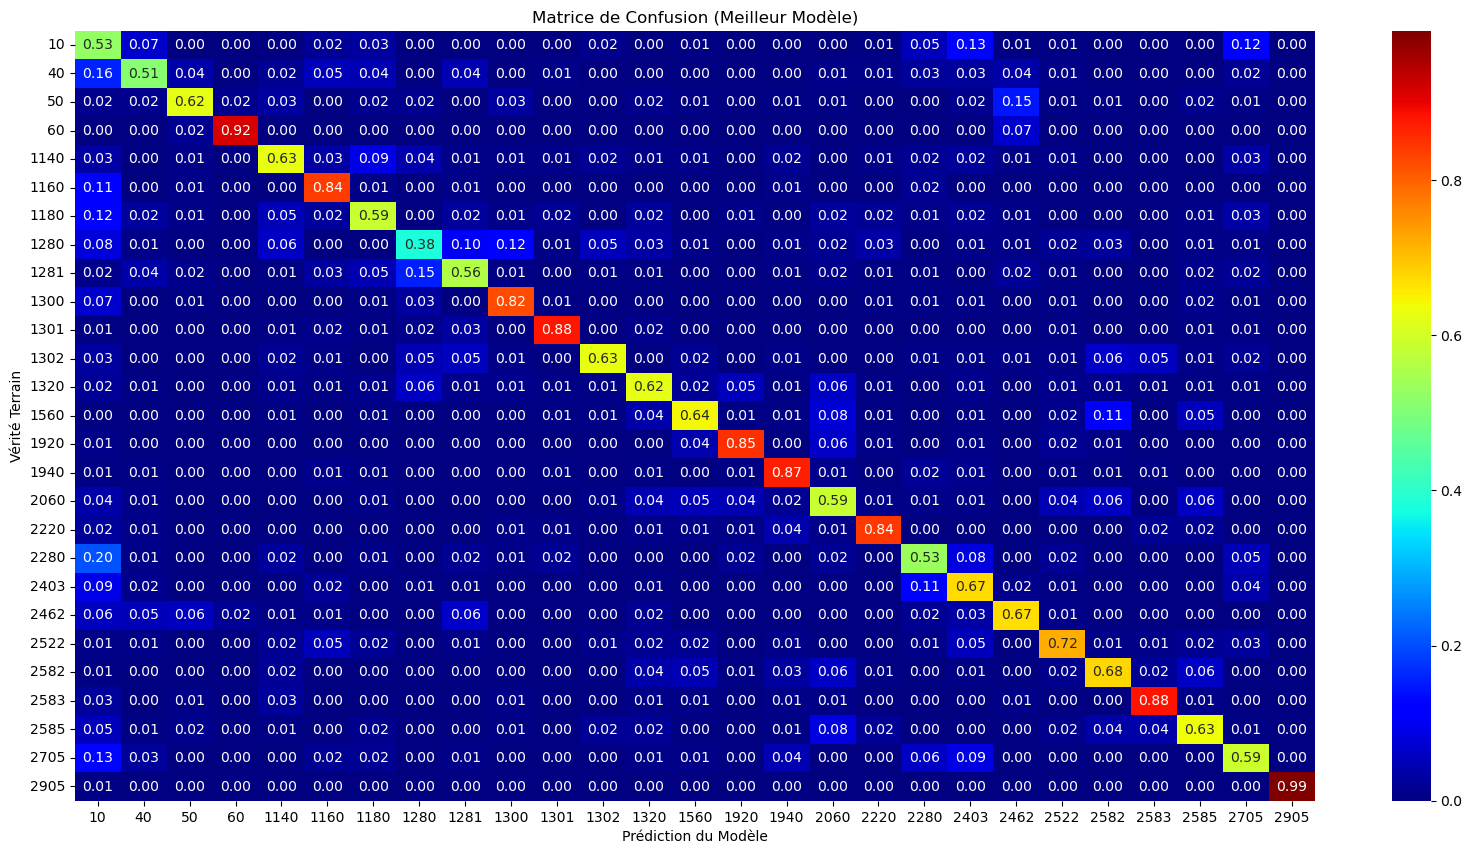

In [57]:
# Création de la heatmap 'sqrt'
plt.figure(figsize = (20, 10))
sns.heatmap(conf_matrix_best_sqrt, annot = True, fmt = '.2f', cmap = 'jet')

# Ajout de titres et d'étiquettes pour la clarté
plt.title('Matrice de Confusion (Meilleur Modèle)')
plt.ylabel('Vérité Terrain')
plt.xlabel('Prédiction du Modèle')

# Affichage du graphe
plt.show()

In [63]:
# Calcul de la matrice de confusion pour les meilleures prédictions 'log2'
conf_matrix_best_log2 = pd.crosstab(y_test,y_pred_best_log2,rownames=['Classe réelle'], colnames=['Classe prédite'],normalize='index')
#display("Matrice de Confusion (Meilleur Modèle pour log 2):\n", conf_matrix_best_log2)

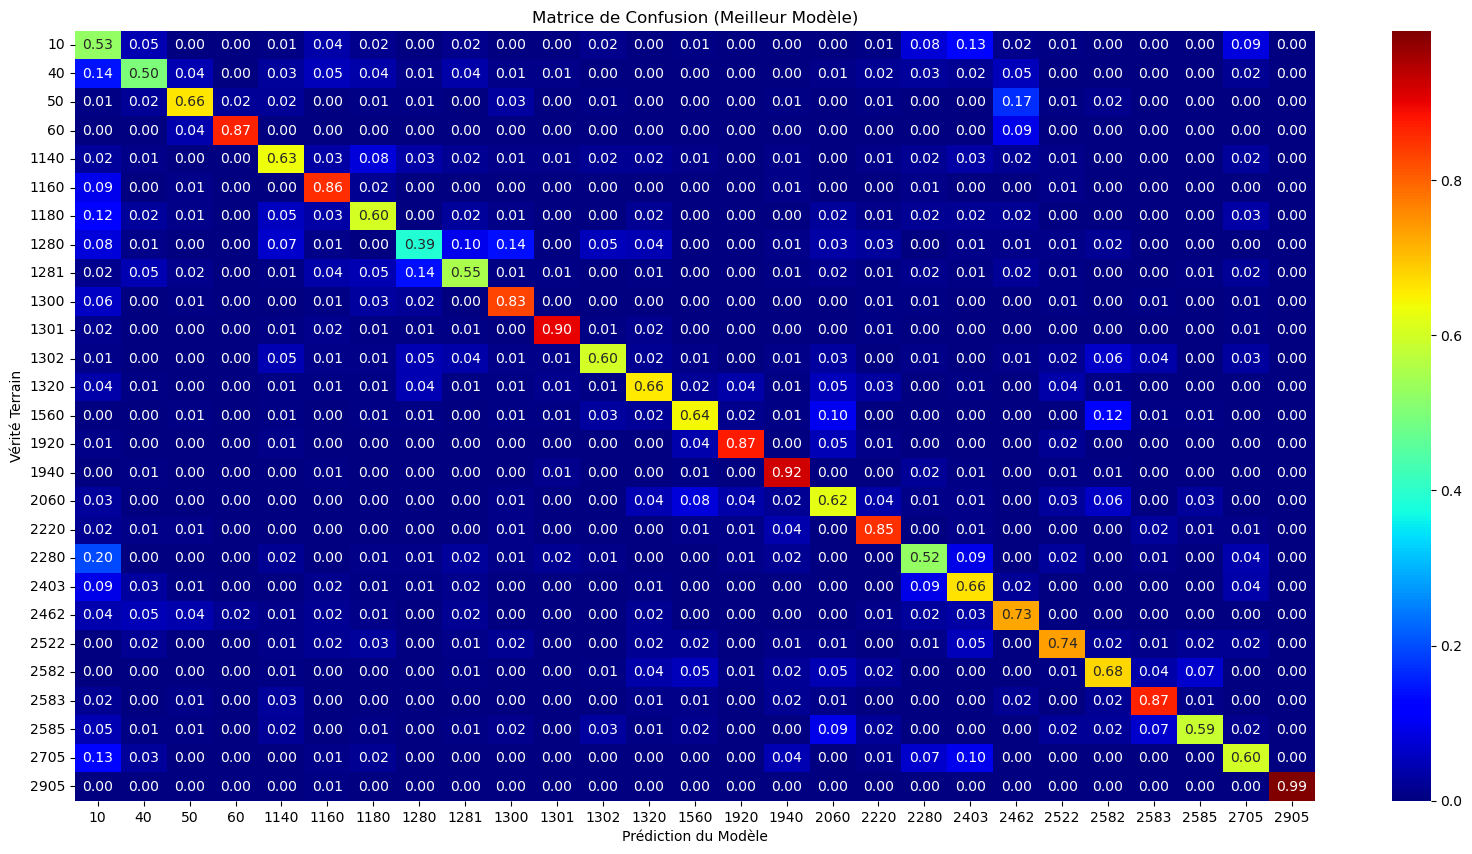

In [60]:
# Création de la heatmap 'log2'
plt.figure(figsize=(20, 10))  # Ajustez la taille selon vos besoins
sns.heatmap(conf_matrix_best_log2, annot=True, fmt='.2f', cmap='jet')

# Ajout de titres et d'étiquettes pour la clarté
plt.title('Matrice de Confusion (Meilleur Modèle)')
plt.ylabel('Vérité Terrain')
plt.xlabel('Prédiction du Modèle')

# Affichage du graphe
plt.show()

In [73]:
## test avec RandomizedSearchCV
# nous cherchons à trouver de meilleurs hyperparamètres

# Définitr l'espace des paramètres
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_dist = {
    'tfidf__max_features': sp_randint(1000, 10000),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], # analyse des combinaisons jusqu'à 3 mots consécutifs
    'tfidf__min_df': sp_randint(1, 10), # fréquence des mots
    'tfidf__max_df': sp_uniform(0.7, 0.3), # fréquence entre 0.7 et 1 (distribution)
    'rf__n_estimators': sp_randint(50, 200), # nombre d'arbres dans la forêt
    'rf__max_features': ['sqrt', 'log2', None],
    'rf__max_depth': sp_randint(10, 50),
    'rf__min_samples_split': sp_randint(2, 11),
    'rf__min_samples_leaf': sp_randint(1, 11)
}

In [78]:
# RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Configurer RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline_test, 
    param_distributions = param_dist, 
    n_iter = 100,  # Nombre d'itérations de configuration de paramètres à essayer
    cv = 5,        # Stratégie de cross-validation
    scoring = {'accuracy': 'accuracy', 'f1_weighted': 'f1_weighted'},  # Nos 2 scores sélectionnés
    refit = 'f1_weighted',  # f1-score pour refit le meilleur modèle
    random_state = 42,
    verbose = 5 # Affiche plus d'informations sur le processus
)

# Exécuter la recherche sur les données
random_search.fit(X_train.iloc[:, 0], y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END rf__max_depth=48, rf__max_features=sqrt, rf__min_samples_leaf=8, rf__min_samples_split=6, rf__n_estimators=152, tfidf__max_df=0.8337498258560773, tfidf__max_features=5426, tfidf__min_df=8, tfidf__ngram_range=(1, 1); accuracy: (test=0.590) f1_weighted: (test=0.607) total time=   1.5s
[CV 2/5] END rf__max_depth=48, rf__max_features=sqrt, rf__min_samples_leaf=8, rf__min_samples_split=6, rf__n_estimators=152, tfidf__max_df=0.8337498258560773, tfidf__max_features=5426, tfidf__min_df=8, tfidf__ngram_range=(1, 1); accuracy: (test=0.598) f1_weighted: (test=0.613) total time=   1.5s
[CV 3/5] END rf__max_depth=48, rf__max_features=sqrt, rf__min_samples_leaf=8, rf__min_samples_split=6, rf__n_estimators=152, tfidf__max_df=0.8337498258560773, tfidf__max_features=5426, tfidf__min_df=8, tfidf__ngram_range=(1, 1); accuracy: (test=0.589) f1_weighted: (test=0.603) total time=   1.5s
[CV 4/5] END rf__max_depth=48, rf__max_feature

[CV 4/5] END rf__max_depth=17, rf__max_features=None, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=99, tfidf__max_df=0.8987566853061946, tfidf__max_features=4073, tfidf__min_df=6, tfidf__ngram_range=(1, 2); accuracy: (test=0.392) f1_weighted: (test=0.439) total time=  24.8s
[CV 5/5] END rf__max_depth=17, rf__max_features=None, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=99, tfidf__max_df=0.8987566853061946, tfidf__max_features=4073, tfidf__min_df=6, tfidf__ngram_range=(1, 2); accuracy: (test=0.348) f1_weighted: (test=0.397) total time=  24.9s
[CV 1/5] END rf__max_depth=13, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=63, tfidf__max_df=0.9181815987569262, tfidf__max_features=8629, tfidf__min_df=7, tfidf__ngram_range=(1, 1); accuracy: (test=0.475) f1_weighted: (test=0.472) total time=   0.4s
[CV 2/5] END rf__max_depth=13, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_est

[CV 2/5] END rf__max_depth=33, rf__max_features=sqrt, rf__min_samples_leaf=3, rf__min_samples_split=9, rf__n_estimators=84, tfidf__max_df=0.8416644775485848, tfidf__max_features=9110, tfidf__min_df=3, tfidf__ngram_range=(1, 1); accuracy: (test=0.598) f1_weighted: (test=0.617) total time=   0.9s
[CV 3/5] END rf__max_depth=33, rf__max_features=sqrt, rf__min_samples_leaf=3, rf__min_samples_split=9, rf__n_estimators=84, tfidf__max_df=0.8416644775485848, tfidf__max_features=9110, tfidf__min_df=3, tfidf__ngram_range=(1, 1); accuracy: (test=0.595) f1_weighted: (test=0.613) total time=   0.9s
[CV 4/5] END rf__max_depth=33, rf__max_features=sqrt, rf__min_samples_leaf=3, rf__min_samples_split=9, rf__n_estimators=84, tfidf__max_df=0.8416644775485848, tfidf__max_features=9110, tfidf__min_df=3, tfidf__ngram_range=(1, 1); accuracy: (test=0.585) f1_weighted: (test=0.604) total time=   1.0s
[CV 5/5] END rf__max_depth=33, rf__max_features=sqrt, rf__min_samples_leaf=3, rf__min_samples_split=9, rf__n_est

[CV 5/5] END rf__max_depth=12, rf__max_features=None, rf__min_samples_leaf=6, rf__min_samples_split=9, rf__n_estimators=186, tfidf__max_df=0.8454489914076949, tfidf__max_features=1663, tfidf__min_df=6, tfidf__ngram_range=(1, 1); accuracy: (test=0.321) f1_weighted: (test=0.361) total time=  25.6s
[CV 1/5] END rf__max_depth=21, rf__max_features=log2, rf__min_samples_leaf=7, rf__min_samples_split=3, rf__n_estimators=180, tfidf__max_df=0.7902634929450308, tfidf__max_features=4696, tfidf__min_df=8, tfidf__ngram_range=(1, 1); accuracy: (test=0.563) f1_weighted: (test=0.564) total time=   0.8s
[CV 2/5] END rf__max_depth=21, rf__max_features=log2, rf__min_samples_leaf=7, rf__min_samples_split=3, rf__n_estimators=180, tfidf__max_df=0.7902634929450308, tfidf__max_features=4696, tfidf__min_df=8, tfidf__ngram_range=(1, 1); accuracy: (test=0.580) f1_weighted: (test=0.578) total time=   0.7s
[CV 3/5] END rf__max_depth=21, rf__max_features=log2, rf__min_samples_leaf=7, rf__min_samples_split=3, rf__n_

[CV 3/5] END rf__max_depth=42, rf__max_features=None, rf__min_samples_leaf=2, rf__min_samples_split=9, rf__n_estimators=178, tfidf__max_df=0.9027070351117842, tfidf__max_features=9120, tfidf__min_df=9, tfidf__ngram_range=(1, 2); accuracy: (test=0.545) f1_weighted: (test=0.585) total time= 1.8min
[CV 4/5] END rf__max_depth=42, rf__max_features=None, rf__min_samples_leaf=2, rf__min_samples_split=9, rf__n_estimators=178, tfidf__max_df=0.9027070351117842, tfidf__max_features=9120, tfidf__min_df=9, tfidf__ngram_range=(1, 2); accuracy: (test=0.543) f1_weighted: (test=0.588) total time= 1.7min
[CV 5/5] END rf__max_depth=42, rf__max_features=None, rf__min_samples_leaf=2, rf__min_samples_split=9, rf__n_estimators=178, tfidf__max_df=0.9027070351117842, tfidf__max_features=9120, tfidf__min_df=9, tfidf__ngram_range=(1, 2); accuracy: (test=0.506) f1_weighted: (test=0.551) total time= 1.7min
[CV 1/5] END rf__max_depth=32, rf__max_features=None, rf__min_samples_leaf=10, rf__min_samples_split=4, rf__n

[CV 1/5] END rf__max_depth=21, rf__max_features=None, rf__min_samples_leaf=3, rf__min_samples_split=7, rf__n_estimators=168, tfidf__max_df=0.7751385455816752, tfidf__max_features=2693, tfidf__min_df=6, tfidf__ngram_range=(1, 2); accuracy: (test=0.385) f1_weighted: (test=0.440) total time=  43.2s
[CV 2/5] END rf__max_depth=21, rf__max_features=None, rf__min_samples_leaf=3, rf__min_samples_split=7, rf__n_estimators=168, tfidf__max_df=0.7751385455816752, tfidf__max_features=2693, tfidf__min_df=6, tfidf__ngram_range=(1, 2); accuracy: (test=0.403) f1_weighted: (test=0.454) total time=  43.4s
[CV 3/5] END rf__max_depth=21, rf__max_features=None, rf__min_samples_leaf=3, rf__min_samples_split=7, rf__n_estimators=168, tfidf__max_df=0.7751385455816752, tfidf__max_features=2693, tfidf__min_df=6, tfidf__ngram_range=(1, 2); accuracy: (test=0.409) f1_weighted: (test=0.458) total time=  43.3s
[CV 4/5] END rf__max_depth=21, rf__max_features=None, rf__min_samples_leaf=3, rf__min_samples_split=7, rf__n_

[CV 4/5] END rf__max_depth=36, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=153, tfidf__max_df=0.9091047222985803, tfidf__max_features=8343, tfidf__min_df=7, tfidf__ngram_range=(1, 1); accuracy: (test=0.603) f1_weighted: (test=0.607) total time=   0.7s
[CV 5/5] END rf__max_depth=36, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=153, tfidf__max_df=0.9091047222985803, tfidf__max_features=8343, tfidf__min_df=7, tfidf__ngram_range=(1, 1); accuracy: (test=0.583) f1_weighted: (test=0.589) total time=   0.8s
[CV 1/5] END rf__max_depth=35, rf__max_features=None, rf__min_samples_leaf=2, rf__min_samples_split=10, rf__n_estimators=62, tfidf__max_df=0.724478254120072, tfidf__max_features=3950, tfidf__min_df=9, tfidf__ngram_range=(1, 1); accuracy: (test=0.512) f1_weighted: (test=0.555) total time=  25.2s
[CV 2/5] END rf__max_depth=35, rf__max_features=None, rf__min_samples_leaf=2, rf__min_samples_split=10, rf__n_

[CV 2/5] END rf__max_depth=28, rf__max_features=log2, rf__min_samples_leaf=7, rf__min_samples_split=6, rf__n_estimators=166, tfidf__max_df=0.7242618899851593, tfidf__max_features=2150, tfidf__min_df=9, tfidf__ngram_range=(1, 1); accuracy: (test=0.576) f1_weighted: (test=0.583) total time=   0.8s
[CV 3/5] END rf__max_depth=28, rf__max_features=log2, rf__min_samples_leaf=7, rf__min_samples_split=6, rf__n_estimators=166, tfidf__max_df=0.7242618899851593, tfidf__max_features=2150, tfidf__min_df=9, tfidf__ngram_range=(1, 1); accuracy: (test=0.558) f1_weighted: (test=0.564) total time=   0.8s
[CV 4/5] END rf__max_depth=28, rf__max_features=log2, rf__min_samples_leaf=7, rf__min_samples_split=6, rf__n_estimators=166, tfidf__max_df=0.7242618899851593, tfidf__max_features=2150, tfidf__min_df=9, tfidf__ngram_range=(1, 1); accuracy: (test=0.565) f1_weighted: (test=0.573) total time=   0.8s
[CV 5/5] END rf__max_depth=28, rf__max_features=log2, rf__min_samples_leaf=7, rf__min_samples_split=6, rf__n_

[CV 5/5] END rf__max_depth=19, rf__max_features=log2, rf__min_samples_leaf=3, rf__min_samples_split=2, rf__n_estimators=118, tfidf__max_df=0.9051891308194423, tfidf__max_features=3839, tfidf__min_df=7, tfidf__ngram_range=(1, 2); accuracy: (test=0.544) f1_weighted: (test=0.558) total time=   1.2s
[CV 1/5] END rf__max_depth=37, rf__max_features=None, rf__min_samples_leaf=4, rf__min_samples_split=9, rf__n_estimators=189, tfidf__max_df=0.8164509778619565, tfidf__max_features=3427, tfidf__min_df=1, tfidf__ngram_range=(1, 1); accuracy: (test=0.515) f1_weighted: (test=0.558) total time= 1.1min
[CV 2/5] END rf__max_depth=37, rf__max_features=None, rf__min_samples_leaf=4, rf__min_samples_split=9, rf__n_estimators=189, tfidf__max_df=0.8164509778619565, tfidf__max_features=3427, tfidf__min_df=1, tfidf__ngram_range=(1, 1); accuracy: (test=0.513) f1_weighted: (test=0.557) total time= 1.2min
[CV 3/5] END rf__max_depth=37, rf__max_features=None, rf__min_samples_leaf=4, rf__min_samples_split=9, rf__n_

[CV 3/5] END rf__max_depth=41, rf__max_features=None, rf__min_samples_leaf=5, rf__min_samples_split=2, rf__n_estimators=62, tfidf__max_df=0.9219726281342123, tfidf__max_features=3914, tfidf__min_df=9, tfidf__ngram_range=(1, 2); accuracy: (test=0.533) f1_weighted: (test=0.570) total time=  26.1s
[CV 4/5] END rf__max_depth=41, rf__max_features=None, rf__min_samples_leaf=5, rf__min_samples_split=2, rf__n_estimators=62, tfidf__max_df=0.9219726281342123, tfidf__max_features=3914, tfidf__min_df=9, tfidf__ngram_range=(1, 2); accuracy: (test=0.532) f1_weighted: (test=0.576) total time=  25.5s
[CV 5/5] END rf__max_depth=41, rf__max_features=None, rf__min_samples_leaf=5, rf__min_samples_split=2, rf__n_estimators=62, tfidf__max_df=0.9219726281342123, tfidf__max_features=3914, tfidf__min_df=9, tfidf__ngram_range=(1, 2); accuracy: (test=0.501) f1_weighted: (test=0.547) total time=  25.1s
[CV 1/5] END rf__max_depth=26, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_es

[CV 1/5] END rf__max_depth=38, rf__max_features=sqrt, rf__min_samples_leaf=6, rf__min_samples_split=4, rf__n_estimators=185, tfidf__max_df=0.8122812387268361, tfidf__max_features=2365, tfidf__min_df=4, tfidf__ngram_range=(1, 1); accuracy: (test=0.580) f1_weighted: (test=0.599) total time=   2.0s
[CV 2/5] END rf__max_depth=38, rf__max_features=sqrt, rf__min_samples_leaf=6, rf__min_samples_split=4, rf__n_estimators=185, tfidf__max_df=0.8122812387268361, tfidf__max_features=2365, tfidf__min_df=4, tfidf__ngram_range=(1, 1); accuracy: (test=0.581) f1_weighted: (test=0.601) total time=   2.0s
[CV 3/5] END rf__max_depth=38, rf__max_features=sqrt, rf__min_samples_leaf=6, rf__min_samples_split=4, rf__n_estimators=185, tfidf__max_df=0.8122812387268361, tfidf__max_features=2365, tfidf__min_df=4, tfidf__ngram_range=(1, 1); accuracy: (test=0.578) f1_weighted: (test=0.596) total time=   2.0s
[CV 4/5] END rf__max_depth=38, rf__max_features=sqrt, rf__min_samples_leaf=6, rf__min_samples_split=4, rf__n_

[CV 4/5] END rf__max_depth=30, rf__max_features=None, rf__min_samples_leaf=5, rf__min_samples_split=5, rf__n_estimators=196, tfidf__max_df=0.9907907606857296, tfidf__max_features=7190, tfidf__min_df=9, tfidf__ngram_range=(1, 1); accuracy: (test=0.488) f1_weighted: (test=0.533) total time= 1.1min
[CV 5/5] END rf__max_depth=30, rf__max_features=None, rf__min_samples_leaf=5, rf__min_samples_split=5, rf__n_estimators=196, tfidf__max_df=0.9907907606857296, tfidf__max_features=7190, tfidf__min_df=9, tfidf__ngram_range=(1, 1); accuracy: (test=0.457) f1_weighted: (test=0.506) total time= 1.1min
[CV 1/5] END rf__max_depth=23, rf__max_features=None, rf__min_samples_leaf=1, rf__min_samples_split=6, rf__n_estimators=103, tfidf__max_df=0.87529429357693, tfidf__max_features=3703, tfidf__min_df=7, tfidf__ngram_range=(1, 1); accuracy: (test=0.407) f1_weighted: (test=0.462) total time=  31.5s
[CV 2/5] END rf__max_depth=23, rf__max_features=None, rf__min_samples_leaf=1, rf__min_samples_split=6, rf__n_es

[CV 2/5] END rf__max_depth=30, rf__max_features=log2, rf__min_samples_leaf=9, rf__min_samples_split=7, rf__n_estimators=108, tfidf__max_df=0.9526356769407125, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1); accuracy: (test=0.575) f1_weighted: (test=0.575) total time=   0.5s
[CV 3/5] END rf__max_depth=30, rf__max_features=log2, rf__min_samples_leaf=9, rf__min_samples_split=7, rf__n_estimators=108, tfidf__max_df=0.9526356769407125, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1); accuracy: (test=0.571) f1_weighted: (test=0.570) total time=   0.5s
[CV 4/5] END rf__max_depth=30, rf__max_features=log2, rf__min_samples_leaf=9, rf__min_samples_split=7, rf__n_estimators=108, tfidf__max_df=0.9526356769407125, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1); accuracy: (test=0.575) f1_weighted: (test=0.576) total time=   0.5s
[CV 5/5] END rf__max_depth=30, rf__max_features=log2, rf__min_samples_leaf=9, rf__min_samples_split=7, rf__n_

[CV 5/5] END rf__max_depth=14, rf__max_features=log2, rf__min_samples_leaf=9, rf__min_samples_split=2, rf__n_estimators=161, tfidf__max_df=0.8440137901055424, tfidf__max_features=2252, tfidf__min_df=5, tfidf__ngram_range=(1, 2); accuracy: (test=0.511) f1_weighted: (test=0.519) total time=   1.2s
[CV 1/5] END rf__max_depth=11, rf__max_features=None, rf__min_samples_leaf=3, rf__min_samples_split=8, rf__n_estimators=87, tfidf__max_df=0.8824263548625655, tfidf__max_features=9017, tfidf__min_df=3, tfidf__ngram_range=(1, 3); accuracy: (test=0.310) f1_weighted: (test=0.340) total time=  19.5s
[CV 2/5] END rf__max_depth=11, rf__max_features=None, rf__min_samples_leaf=3, rf__min_samples_split=8, rf__n_estimators=87, tfidf__max_df=0.8824263548625655, tfidf__max_features=9017, tfidf__min_df=3, tfidf__ngram_range=(1, 3); accuracy: (test=0.330) f1_weighted: (test=0.364) total time=  19.7s
[CV 3/5] END rf__max_depth=11, rf__max_features=None, rf__min_samples_leaf=3, rf__min_samples_split=8, rf__n_es

[CV 3/5] END rf__max_depth=36, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=196, tfidf__max_df=0.9465371910533347, tfidf__max_features=6585, tfidf__min_df=6, tfidf__ngram_range=(1, 1); accuracy: (test=0.609) f1_weighted: (test=0.629) total time=   2.3s
[CV 4/5] END rf__max_depth=36, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=196, tfidf__max_df=0.9465371910533347, tfidf__max_features=6585, tfidf__min_df=6, tfidf__ngram_range=(1, 1); accuracy: (test=0.603) f1_weighted: (test=0.624) total time=   2.3s
[CV 5/5] END rf__max_depth=36, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=196, tfidf__max_df=0.9465371910533347, tfidf__max_features=6585, tfidf__min_df=6, tfidf__ngram_range=(1, 1); accuracy: (test=0.593) f1_weighted: (test=0.614) total time=   2.5s
[CV 1/5] END rf__max_depth=15, rf__max_features=sqrt, rf__min_samples_leaf=5, rf__min_samples_split=10, rf__n

[CV 1/5] END rf__max_depth=46, rf__max_features=log2, rf__min_samples_leaf=7, rf__min_samples_split=10, rf__n_estimators=66, tfidf__max_df=0.7634344020989634, tfidf__max_features=8641, tfidf__min_df=9, tfidf__ngram_range=(1, 1); accuracy: (test=0.580) f1_weighted: (test=0.580) total time=   0.5s
[CV 2/5] END rf__max_depth=46, rf__max_features=log2, rf__min_samples_leaf=7, rf__min_samples_split=10, rf__n_estimators=66, tfidf__max_df=0.7634344020989634, tfidf__max_features=8641, tfidf__min_df=9, tfidf__ngram_range=(1, 1); accuracy: (test=0.591) f1_weighted: (test=0.593) total time=   0.5s
[CV 3/5] END rf__max_depth=46, rf__max_features=log2, rf__min_samples_leaf=7, rf__min_samples_split=10, rf__n_estimators=66, tfidf__max_df=0.7634344020989634, tfidf__max_features=8641, tfidf__min_df=9, tfidf__ngram_range=(1, 1); accuracy: (test=0.576) f1_weighted: (test=0.571) total time=   0.5s
[CV 4/5] END rf__max_depth=46, rf__max_features=log2, rf__min_samples_leaf=7, rf__min_samples_split=10, rf__n

[CV 4/5] END rf__max_depth=45, rf__max_features=None, rf__min_samples_leaf=6, rf__min_samples_split=3, rf__n_estimators=124, tfidf__max_df=0.959652137768194, tfidf__max_features=9837, tfidf__min_df=6, tfidf__ngram_range=(1, 1); accuracy: (test=0.540) f1_weighted: (test=0.581) total time=  53.6s
[CV 5/5] END rf__max_depth=45, rf__max_features=None, rf__min_samples_leaf=6, rf__min_samples_split=3, rf__n_estimators=124, tfidf__max_df=0.959652137768194, tfidf__max_features=9837, tfidf__min_df=6, tfidf__ngram_range=(1, 1); accuracy: (test=0.508) f1_weighted: (test=0.550) total time=  53.8s
[CV 1/5] END rf__max_depth=39, rf__max_features=log2, rf__min_samples_leaf=3, rf__min_samples_split=10, rf__n_estimators=128, tfidf__max_df=0.8605110196134731, tfidf__max_features=7316, tfidf__min_df=5, tfidf__ngram_range=(1, 2); accuracy: (test=0.593) f1_weighted: (test=0.601) total time=   1.3s
[CV 2/5] END rf__max_depth=39, rf__max_features=log2, rf__min_samples_leaf=3, rf__min_samples_split=10, rf__n_

[CV 2/5] END rf__max_depth=20, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=84, tfidf__max_df=0.9779348270769133, tfidf__max_features=4391, tfidf__min_df=6, tfidf__ngram_range=(1, 1); accuracy: (test=0.576) f1_weighted: (test=0.595) total time=   0.8s
[CV 3/5] END rf__max_depth=20, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=84, tfidf__max_df=0.9779348270769133, tfidf__max_features=4391, tfidf__min_df=6, tfidf__ngram_range=(1, 1); accuracy: (test=0.565) f1_weighted: (test=0.586) total time=   0.8s
[CV 4/5] END rf__max_depth=20, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_estimators=84, tfidf__max_df=0.9779348270769133, tfidf__max_features=4391, tfidf__min_df=6, tfidf__ngram_range=(1, 1); accuracy: (test=0.559) f1_weighted: (test=0.577) total time=   0.8s
[CV 5/5] END rf__max_depth=20, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=4, rf__n_est

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('rf',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=100,
                   param_distributions={'rf__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15630ca10>,
                                        'rf__max_features': ['sqrt', 'log2',
                                                             None],
                                        'rf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_...
                                        'tfidf__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15638b3d0>,
                                        'tfidf__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x156355c90>,
                                        'tfidf__min_df': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x156381a50>,
                                        'tfidf__ngram_range': [(1, 1), (1, 2),
                                                               (1, 3)]},
                   random_state=42, refit='f1_weighted',
                   scoring={'accuracy': 'accuracy',
                            'f1_weighted': 'f1_weighted'},
                   verbose=5)

In [79]:
# Analyse des résultats

print("Meilleurs Paramètres:", random_search.best_params_)
print("Meilleure Précision:", random_search.best_score_)

# Meilleur modèle pour faire des prédictions sur l'ensemble de test
y_pred = random_search.predict(X_test.iloc[:, 0])

# Calcul et affichage de la performance sur l'ensemble de test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy sur l'ensemble de test:", accuracy)

# prendre le f1 score plutot que l'accuracy ? ou sortir les 2

Meilleurs Paramètres: {'rf__max_depth': 49, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 6, 'rf__n_estimators': 73, 'tfidf__max_df': 0.8070259980080767, 'tfidf__max_features': 5859, 'tfidf__min_df': 9, 'tfidf__ngram_range': (1, 1)}
Meilleure Précision: 0.6309704175395068
Accuracy sur l'ensemble de test: 0.627893175074184


J'affine ma recherche autour des valeurs que j'ai trouvé au début avec gridSearchCv :

tfidf__max_features : Je choisis une plage autour de 5000, mais j'étends la recherche (augmenter ou réduire ce nombre peut améliorer la performance).

tfidf__min_df et tfidf__max_df : Ces paramètres contrôlent la fréquence des termes pris en compte par le vectoriseur TF-IDF. Nous n'en avions pas mis dans GridSearchCV, nous prenons des valeurs standards (basses pour min et hautes pour max).

tfidf__ngram_range : Nous prenons en compte les groupes de un ou deux mots successifs, (les groupes de trois nous augmentent trop le temps de recherche).

rf__n_estimators : Nous restons autour de 100 comme trouvé avec GridSearchCV mais avec une marge haute et basse pour voir si nous pouvons obtenir des améliorations.

rf__max_features : Nous testons avec 'sqrt' et 'log2' sachant que nous avions des résultats relativement proche.

rf__max_depth, rf__min_samples_split, rf__min_samples_leaf : On évite le surajustement pour différentes profondeurs.

In [82]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist_2 = {
    'tfidf__max_features': sp_randint(3000, 7000),  
    'tfidf__min_df': [1, 3, 5, 7, 9],  
    'tfidf__max_df': uniform(0.75, 0.95),  
    'tfidf__ngram_range': [(1, 1), (1, 2)],  
    'rf__n_estimators': sp_randint(80, 120),
    'rf__max_features': ['sqrt', 'log2'],
    'rf__max_depth': [None, 10, 20, 30, 40, 50],
    'rf__min_samples_split': sp_randint(2, 10),
    'rf__min_samples_leaf': sp_randint(1, 5)
}

In [83]:
# Config RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline_test, 
    param_distributions = param_dist_2, 
    n_iter = 100,
    cv = 5,
    scoring = {'accuracy': 'accuracy', 'f1_weighted': 'f1_weighted'},  # Nos 2 scores sélectionnés
    refit = 'f1_weighted',  # f1-score pour refit le meilleur modèle
    random_state = 42,
    verbose = 5 # Affiche plus d'informations sur le processus
)

# Exécuter la recherche sur les données
random_search.fit(X_train.iloc[:, 0], y_train) 


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=3, rf__min_samples_split=4, rf__n_estimators=87, tfidf__max_df=1.3187255599871848, tfidf__max_features=4638, tfidf__min_df=3, tfidf__ngram_range=(1, 1); accuracy: (test=nan) f1_weighted: (test=nan) total time=   0.0s
[CV 2/5] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=3, rf__min_samples_split=4, rf__n_estimators=87, tfidf__max_df=1.3187255599871848, tfidf__max_features=4638, tfidf__min_df=3, tfidf__ngram_range=(1, 1); accuracy: (test=nan) f1_weighted: (test=nan) total time=   0.0s
[CV 3/5] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=3, rf__min_samples_split=4, rf__n_estimators=87, tfidf__max_df=1.3187255599871848, tfidf__max_features=4638, tfidf__min_df=3, tfidf__ngram_range=(1, 1); accuracy: (test=nan) f1_weighted: (test=nan) total time=   0.0s
[CV 4/5] END rf__max_depth=30, rf__max_features=sqrt, rf__min

[CV 1/5] END rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=87, tfidf__max_df=0.7552460112674223, tfidf__max_features=4162, tfidf__min_df=5, tfidf__ngram_range=(1, 1); accuracy: (test=0.687) f1_weighted: (test=0.687) total time=   2.8s
[CV 2/5] END rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=87, tfidf__max_df=0.7552460112674223, tfidf__max_features=4162, tfidf__min_df=5, tfidf__ngram_range=(1, 1); accuracy: (test=0.694) f1_weighted: (test=0.695) total time=   2.8s
[CV 3/5] END rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=87, tfidf__max_df=0.7552460112674223, tfidf__max_features=4162, tfidf__min_df=5, tfidf__ngram_range=(1, 1); accuracy: (test=0.685) f1_weighted: (test=0.685) total time=   2.8s
[CV 4/5] END rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=1, rf__min_samples_split=5, r

[CV 1/5] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=107, tfidf__max_df=0.9575184153559919, tfidf__max_features=4363, tfidf__min_df=5, tfidf__ngram_range=(1, 2); accuracy: (test=0.652) f1_weighted: (test=0.659) total time=   3.5s
[CV 2/5] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=107, tfidf__max_df=0.9575184153559919, tfidf__max_features=4363, tfidf__min_df=5, tfidf__ngram_range=(1, 2); accuracy: (test=0.663) f1_weighted: (test=0.668) total time=   3.4s
[CV 3/5] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=107, tfidf__max_df=0.9575184153559919, tfidf__max_features=4363, tfidf__min_df=5, tfidf__ngram_range=(1, 2); accuracy: (test=0.657) f1_weighted: (test=0.663) total time=   3.4s
[CV 4/5] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=5

[CV 1/5] END rf__max_depth=40, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=5, rf__n_estimators=115, tfidf__max_df=0.7657584374814633, tfidf__max_features=4986, tfidf__min_df=5, tfidf__ngram_range=(1, 2); accuracy: (test=0.587) f1_weighted: (test=0.610) total time=   2.1s
[CV 2/5] END rf__max_depth=40, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=5, rf__n_estimators=115, tfidf__max_df=0.7657584374814633, tfidf__max_features=4986, tfidf__min_df=5, tfidf__ngram_range=(1, 2); accuracy: (test=0.592) f1_weighted: (test=0.612) total time=   2.0s
[CV 3/5] END rf__max_depth=40, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=5, rf__n_estimators=115, tfidf__max_df=0.7657584374814633, tfidf__max_features=4986, tfidf__min_df=5, tfidf__ngram_range=(1, 2); accuracy: (test=0.594) f1_weighted: (test=0.613) total time=   2.0s
[CV 4/5] END rf__max_depth=40, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=5, rf__n_

[CV 1/5] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=3, rf__min_samples_split=7, rf__n_estimators=101, tfidf__max_df=0.9817901612101294, tfidf__max_features=5085, tfidf__min_df=9, tfidf__ngram_range=(1, 1); accuracy: (test=0.579) f1_weighted: (test=0.600) total time=   1.1s
[CV 2/5] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=3, rf__min_samples_split=7, rf__n_estimators=101, tfidf__max_df=0.9817901612101294, tfidf__max_features=5085, tfidf__min_df=9, tfidf__ngram_range=(1, 1); accuracy: (test=0.593) f1_weighted: (test=0.612) total time=   1.1s
[CV 3/5] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=3, rf__min_samples_split=7, rf__n_estimators=101, tfidf__max_df=0.9817901612101294, tfidf__max_features=5085, tfidf__min_df=9, tfidf__ngram_range=(1, 1); accuracy: (test=0.586) f1_weighted: (test=0.604) total time=   1.1s
[CV 4/5] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=3, rf__min_samples_split=7, rf__n_

[CV 1/5] END rf__max_depth=50, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=102, tfidf__max_df=0.7762359332800195, tfidf__max_features=6425, tfidf__min_df=3, tfidf__ngram_range=(1, 2); accuracy: (test=0.602) f1_weighted: (test=0.609) total time=   1.3s
[CV 2/5] END rf__max_depth=50, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=102, tfidf__max_df=0.7762359332800195, tfidf__max_features=6425, tfidf__min_df=3, tfidf__ngram_range=(1, 2); accuracy: (test=0.620) f1_weighted: (test=0.631) total time=   1.3s
[CV 3/5] END rf__max_depth=50, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=102, tfidf__max_df=0.7762359332800195, tfidf__max_features=6425, tfidf__min_df=3, tfidf__ngram_range=(1, 2); accuracy: (test=0.608) f1_weighted: (test=0.614) total time=   1.3s
[CV 4/5] END rf__max_depth=50, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_

[CV 1/5] END rf__max_depth=20, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=9, rf__n_estimators=116, tfidf__max_df=0.86415641541536, tfidf__max_features=6356, tfidf__min_df=7, tfidf__ngram_range=(1, 1); accuracy: (test=0.554) f1_weighted: (test=0.557) total time=   0.5s
[CV 2/5] END rf__max_depth=20, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=9, rf__n_estimators=116, tfidf__max_df=0.86415641541536, tfidf__max_features=6356, tfidf__min_df=7, tfidf__ngram_range=(1, 1); accuracy: (test=0.572) f1_weighted: (test=0.575) total time=   0.5s
[CV 3/5] END rf__max_depth=20, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=9, rf__n_estimators=116, tfidf__max_df=0.86415641541536, tfidf__max_features=6356, tfidf__min_df=7, tfidf__ngram_range=(1, 1); accuracy: (test=0.566) f1_weighted: (test=0.568) total time=   0.5s
[CV 4/5] END rf__max_depth=20, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=9, rf__n_estima

[CV 1/5] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=6, rf__n_estimators=92, tfidf__max_df=0.9538596637229554, tfidf__max_features=6373, tfidf__min_df=3, tfidf__ngram_range=(1, 1); accuracy: (test=0.476) f1_weighted: (test=0.484) total time=   0.6s
[CV 2/5] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=6, rf__n_estimators=92, tfidf__max_df=0.9538596637229554, tfidf__max_features=6373, tfidf__min_df=3, tfidf__ngram_range=(1, 1); accuracy: (test=0.511) f1_weighted: (test=0.523) total time=   0.6s
[CV 3/5] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=6, rf__n_estimators=92, tfidf__max_df=0.9538596637229554, tfidf__max_features=6373, tfidf__min_df=3, tfidf__ngram_range=(1, 1); accuracy: (test=0.511) f1_weighted: (test=0.519) total time=   0.6s
[CV 4/5] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=6, rf__n_est

[CV 1/5] END rf__max_depth=30, rf__max_features=log2, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=98, tfidf__max_df=0.8367223429468269, tfidf__max_features=5502, tfidf__min_df=7, tfidf__ngram_range=(1, 2); accuracy: (test=0.602) f1_weighted: (test=0.613) total time=   1.3s
[CV 2/5] END rf__max_depth=30, rf__max_features=log2, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=98, tfidf__max_df=0.8367223429468269, tfidf__max_features=5502, tfidf__min_df=7, tfidf__ngram_range=(1, 2); accuracy: (test=0.605) f1_weighted: (test=0.620) total time=   1.3s
[CV 3/5] END rf__max_depth=30, rf__max_features=log2, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=98, tfidf__max_df=0.8367223429468269, tfidf__max_features=5502, tfidf__min_df=7, tfidf__ngram_range=(1, 2); accuracy: (test=0.612) f1_weighted: (test=0.626) total time=   1.3s
[CV 4/5] END rf__max_depth=30, rf__max_features=log2, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_est

[CV 4/5] END rf__max_depth=50, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=6, rf__n_estimators=119, tfidf__max_df=0.8191248560459838, tfidf__max_features=5993, tfidf__min_df=5, tfidf__ngram_range=(1, 2); accuracy: (test=0.611) f1_weighted: (test=0.635) total time=   2.3s
[CV 5/5] END rf__max_depth=50, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=6, rf__n_estimators=119, tfidf__max_df=0.8191248560459838, tfidf__max_features=5993, tfidf__min_df=5, tfidf__ngram_range=(1, 2); accuracy: (test=0.589) f1_weighted: (test=0.613) total time=   2.3s
[CV 1/5] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=6, rf__n_estimators=117, tfidf__max_df=1.6873075995761166, tfidf__max_features=4519, tfidf__min_df=9, tfidf__ngram_range=(1, 1); accuracy: (test=nan) f1_weighted: (test=nan) total time=   0.0s
[CV 2/5] END rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=6, rf__n_esti

[CV 2/5] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=9, rf__n_estimators=112, tfidf__max_df=0.96241604659348, tfidf__max_features=3133, tfidf__min_df=3, tfidf__ngram_range=(1, 2); accuracy: (test=0.589) f1_weighted: (test=0.616) total time=   2.0s
[CV 3/5] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=9, rf__n_estimators=112, tfidf__max_df=0.96241604659348, tfidf__max_features=3133, tfidf__min_df=3, tfidf__ngram_range=(1, 2); accuracy: (test=0.585) f1_weighted: (test=0.607) total time=   2.0s
[CV 4/5] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=9, rf__n_estimators=112, tfidf__max_df=0.96241604659348, tfidf__max_features=3133, tfidf__min_df=3, tfidf__ngram_range=(1, 2); accuracy: (test=0.582) f1_weighted: (test=0.608) total time=   2.0s
[CV 5/5] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=9, rf__n_estima

[CV 1/5] END rf__max_depth=10, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=84, tfidf__max_df=0.7750486257723894, tfidf__max_features=4824, tfidf__min_df=1, tfidf__ngram_range=(1, 2); accuracy: (test=0.484) f1_weighted: (test=0.491) total time=   1.0s
[CV 2/5] END rf__max_depth=10, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=84, tfidf__max_df=0.7750486257723894, tfidf__max_features=4824, tfidf__min_df=1, tfidf__ngram_range=(1, 2); accuracy: (test=0.497) f1_weighted: (test=0.507) total time=   1.0s
[CV 3/5] END rf__max_depth=10, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_estimators=84, tfidf__max_df=0.7750486257723894, tfidf__max_features=4824, tfidf__min_df=1, tfidf__ngram_range=(1, 2); accuracy: (test=0.503) f1_weighted: (test=0.501) total time=   1.0s
[CV 4/5] END rf__max_depth=10, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=3, rf__n_est

[CV 1/5] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=7, rf__n_estimators=96, tfidf__max_df=0.8773144670281087, tfidf__max_features=6374, tfidf__min_df=9, tfidf__ngram_range=(1, 1); accuracy: (test=0.588) f1_weighted: (test=0.608) total time=   1.2s
[CV 2/5] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=7, rf__n_estimators=96, tfidf__max_df=0.8773144670281087, tfidf__max_features=6374, tfidf__min_df=9, tfidf__ngram_range=(1, 1); accuracy: (test=0.601) f1_weighted: (test=0.622) total time=   1.1s
[CV 3/5] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=7, rf__n_estimators=96, tfidf__max_df=0.8773144670281087, tfidf__max_features=6374, tfidf__min_df=9, tfidf__ngram_range=(1, 1); accuracy: (test=0.593) f1_weighted: (test=0.612) total time=   1.1s
[CV 4/5] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=7, rf__n_est

/Users/shawnspenstar/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
370 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/shawnspenstar/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawnspenstar/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/shawnspenstar/anaconda3/lib/python3.11/site-packages

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('rf',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=100,
                   param_distributions={'rf__max_depth': [None, 10, 20, 30, 40,
                                                          50],
                                        'rf__max_features': ['sqrt', 'log2'],
                                        'rf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x15745b010>,
                                        'rf__min_samples_spli...
                                        'tfidf__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15da53fd0>,
                                        'tfidf__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x156388190>,
                                        'tfidf__min_df': [1, 3, 5, 7, 9],
                                        'tfidf__ngram_range': [(1, 1), (1, 2)]},
                   random_state=42, refit='f1_weighted',
                   scoring={'accuracy': 'accuracy',
                            'f1_weighted': 'f1_weighted'},
                   verbose=5)

In [84]:
# Analyse des résultats

print("Meilleurs Paramètres:", random_search.best_params_)
print("Meilleure Précision:", random_search.best_score_)

# Utiliser le meilleur modèle pour faire des prédictions sur l'ensemble de test
y_pred = random_search.predict(X_test.iloc[:, 0])

# Calculer et afficher la performance sur l'ensemble de test
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy sur l'ensemble de test:", accuracy)

Meilleurs Paramètres: {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 3, 'rf__n_estimators': 91, 'tfidf__max_df': 0.9891931810340959, 'tfidf__max_features': 6457, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}
Meilleure Précision: 0.6978348251516616
Accuracy sur l'ensemble de test: 0.7071216617210683
